In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # select GPUs to use

In [2]:
import torchphysics as tp
#import copy
import numpy as np
import torch
import pytorch_lightning as pl
import scipy.io
from scipy.interpolate import griddata
import time
import matplotlib.gridspec as gridspec
from matplotlib import pyplot as plt
%matplotlib inline

from torchphysics.problem.conditions.condition import  DataCondition, HPM_EquationLoss_at_Sampler

/home/ibp5kor/.conda/envs/torchphysics/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import torch
import sys
print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__CUDA VERSION')
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')
print('Active CUDA Device: GPU', torch.cuda.current_device())
print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device())
np.random.seed(1234)


__Python VERSION: 3.7.16 (default, Jan 17 2023, 22:20:44) 
[GCC 11.2.0]
__pyTorch VERSION: 1.13.1
__CUDA VERSION
__CUDNN VERSION: 8500
__Number CUDA Devices: 1
__Devices
Active CUDA Device: GPU 0
Available devices  1
Current cuda device  0


In [7]:
def oscillator_state(state, t, delta, alpha, beta, input_func):

    x,vx = state
            
    state_dt = [vx, -delta*vx - alpha*x - beta*x**3 + input_func(t)]

    return state_dt

In [8]:
delta = 0.3
omega = 1.2
alpha = -1.0
beta  = 1.0
gamma = 0.2
state0 = [1.0, 0.]
Tp= 2*np.pi/omega
tfinal = 40*Tp   #10.0
dt =  0.01
t =  np.arange(0.0,tfinal+dt,dt)


def input_function(t):
    return np.random.randn() #gamma*np.cos(omega*t) #np.random.randn()


In [9]:
len(t)

20945

In [10]:
def rungekutta4(func, y0, t, input_sig, args=()):
    n = len(t)
    y = np.zeros((n, len(y0)))
    y[0] = y0
    for i in range(n - 1):
        h = t[i+1] - t[i]
        k1 = func(y[i], t[i],input_sig[i], *args)
        k2 = func(y[i] + k1 * h / 2., t[i] + h / 2.,input_sig[i], *args)
        k3 = func(y[i] + k2 * h / 2., t[i] + h / 2.,input_sig[i], *args)
        k4 = func(y[i] + k3 * h, t[i] + h,input_sig[i], *args)
        y[i+1] = y[i] + (h / 6.) * (k1 + 2*k2 + 2*k3 + k4)
    return y

def euler_forward(func, y0, t,input_sig, args=()):
    n = len(t)
    y = np.zeros((n, len(y0)))
    y[0] = y0
    for i in range(n - 1):
        y[i+1] = y[i] + (t[i+1] - t[i]) * np.array(func(y[i], t[i],input_sig[i], *args))
    return y


In [11]:
def oscillator_state2(t,state, delta, alpha, beta, input_func):

    x,vx = state
            
    fx = vx
    fy = -delta*vx - alpha*x - beta*x**3 + input_func(t)

    return fx,fy

In [12]:
from scipy.integrate import solve_ivp
sol = solve_ivp(oscillator_state2, t_span=(t[0], t[-1]), y0=state0,t_eval=t, args=(delta, alpha, beta,input_function))

In [13]:
sol.y


array([[ 1.00000000e+00,  1.00000264e+00,  1.00000616e+00, ...,
         1.01710715e+00,  1.01691633e+00,  1.01673132e+00],
       [ 0.00000000e+00,  4.12832475e-04,  6.75690327e-04, ...,
        -2.05816164e-02, -1.87396914e-02, -1.99805486e-02]])

In [22]:
x,vx=sol.y

In [23]:
np_datatype = np.float64
t_start,t_end = 0.0,100.0

x_store , vx_store, t_store = [],[],[]

for i in range(len(t)):
    if t[i]>=t_start and t[i]<=t_end:
        x_store.append(x[i])
        vx_store.append(vx[i])
        t_store.append(t[i])

x_store = np.array(x_store).astype(np_datatype)
vx_store = np.array(vx_store).astype(np_datatype)
t_store = np.array(t_store).astype(np_datatype)

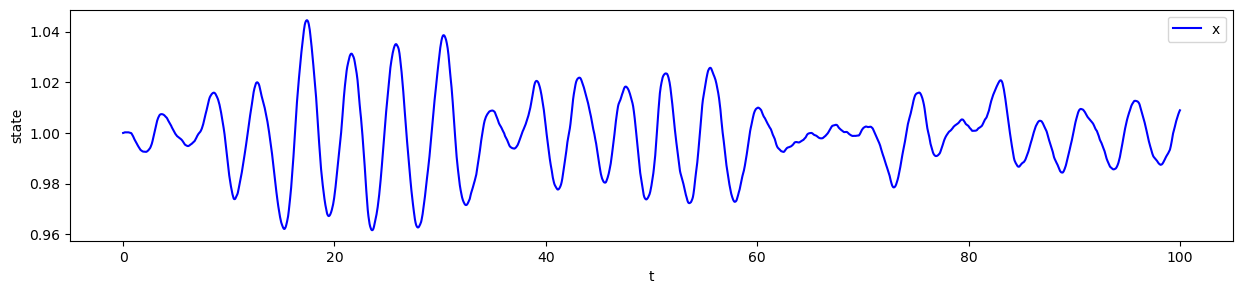

In [24]:
plt.figure(figsize=(15,3))
plt.plot(t_store, x_store, 'b', label='x')
#plt.plot(t, vx, 'g', label='vx')
plt.legend()
plt.xlabel('t')
plt.ylabel('state')
plt.show()

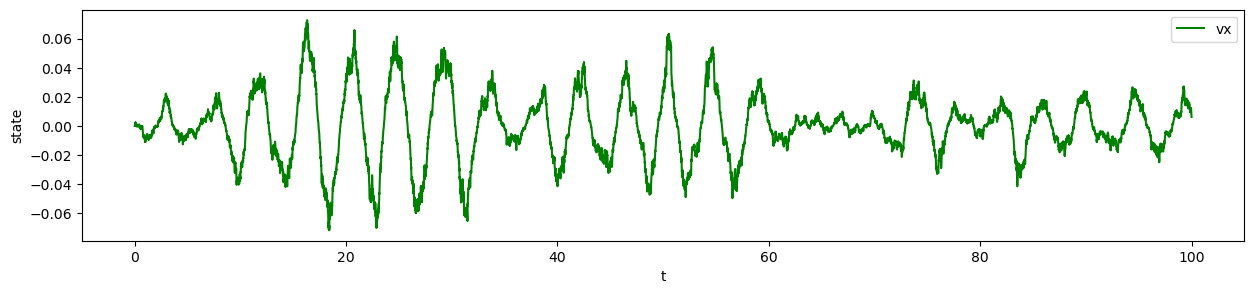

In [25]:
plt.figure(figsize=(15,3))
#plt.plot(t, x, 'b', label='x')
plt.plot(t_store, vx_store, 'g', label='vx')
plt.legend()
plt.xlabel('t')
plt.ylabel('state')
plt.show()

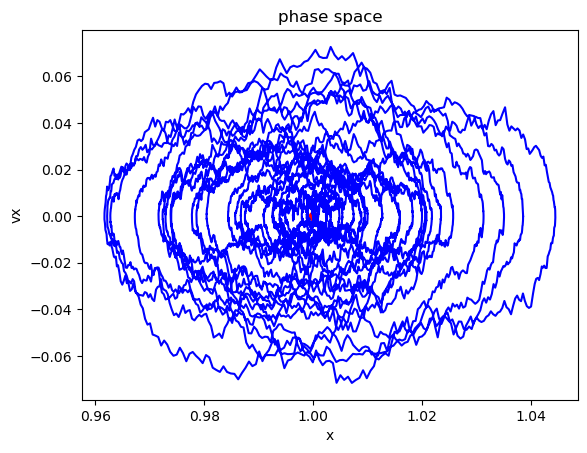

In [26]:
plt.figure()
plt.plot(x_store,vx_store,c='b')
plt.scatter(x_store[0],vx_store[0],c='r')
plt.xlabel('x')
plt.ylabel('vx')
plt.title('phase space')
plt.show()

In [28]:
t_data_exact = t_store.copy()
x_data_exact = x_store.copy()
vx_data_exact = vx_store.copy()

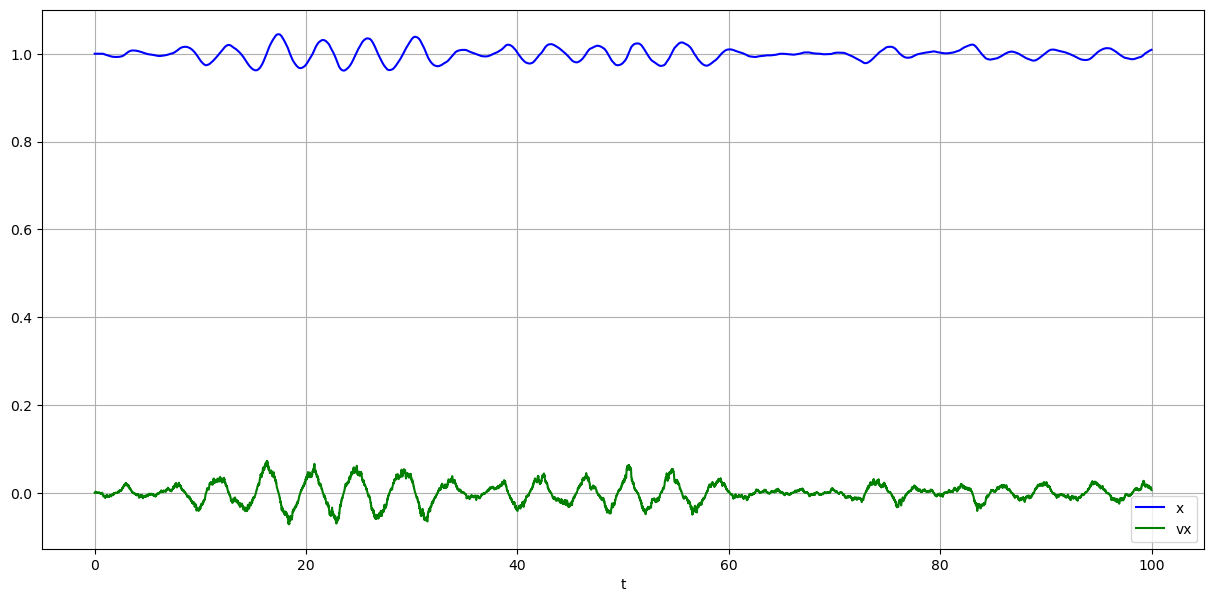

In [29]:
plt.figure(figsize=(15, 7))
plt.plot(t_data_exact,x_data_exact,c='b',label='x')
plt.plot(t_data_exact,vx_data_exact,c='g',label='vx')
plt.xlabel('t')
plt.grid('True')
plt.legend()
plt.show()

In [30]:
train_data = 100
filter_data = np.random.choice(len(t), train_data, replace=False)

In [31]:
print('training data percentage:  ',train_data*100/len(t_data_exact),'%')

training data percentage:   0.9999000099990001 %


In [32]:
t_c = np.max(np.abs(t_data_exact))
x_c = np.max(np.abs(x_data_exact))
vx_c = np.max(np.abs(vx_data_exact))

In [33]:
t_scale = t/t_c
x_scale = x/x_c
vx_scale = vx/vx_c

In [34]:
t_tensor = torch.tensor(t_scale,dtype=torch.float32)
x_tensor = torch.tensor(x_scale,dtype=torch.float32)
vx_tensor = torch.tensor(vx_scale,dtype=torch.float32)

In [35]:
t_tensor_train = t_tensor[filter_data]
x_tensor_train = x_tensor[filter_data]
vx_tensor_train = vx_tensor[filter_data]

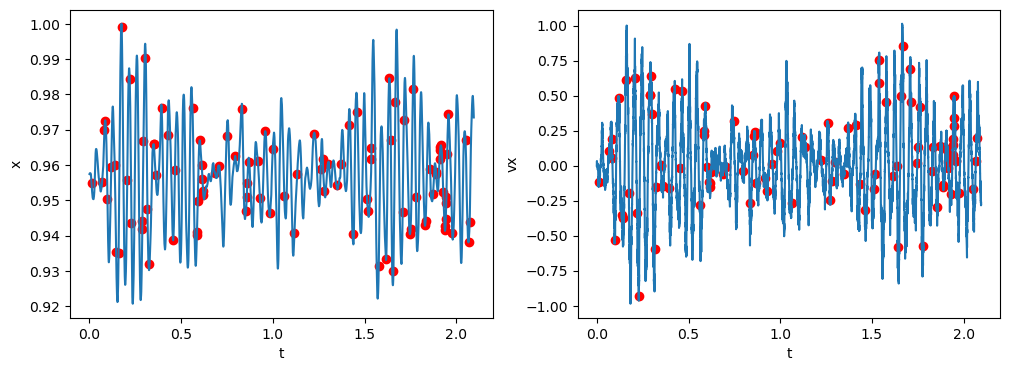

In [36]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.scatter(t_tensor_train.numpy().flatten(),x_tensor_train.numpy().flatten(),c='r')
plt.plot(t_tensor.numpy().flatten(),x_tensor.numpy().flatten())
plt.xlabel('t')
plt.ylabel('x')

plt.subplot(122)
plt.scatter(t_tensor_train.numpy().flatten(),vx_tensor_train.numpy().flatten(),c='r')
plt.plot(t_tensor.numpy().flatten(),vx_tensor.numpy().flatten())
plt.xlabel('t')
plt.ylabel('vx')
plt.show()

In [38]:
T = tp.spaces.R1('t') # input space (t)
State = tp.spaces.R2('state') # output space (x,vx)
X = tp.spaces.R1('x')
X2 = tp.spaces.R1('x2')
X3 = tp.spaces.R1('x3')
T2 = tp.spaces.R1('t2')
T3 = tp.spaces.R1('t3')
Vx = tp.spaces.R1('vx')

N_hid = tp.spaces.R1('N_hid')

In [39]:
I     = tp.domains.Interval(space=T, lower_bound=t_scale.min(), upper_bound=t_scale.max())

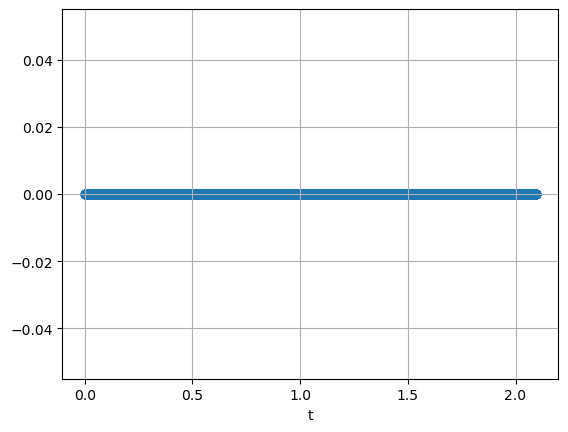

In [40]:
domain_sampler = tp.samplers.RandomUniformSampler(I, n_points=10000)
plot           = tp.utils.scatter(T, domain_sampler)

In [41]:
normalization_layer = tp.models.NormalizationLayer(I)
fcn_layer           = tp.models.FCN(input_space=T, output_space=State, hidden = (100,100,100))

In [42]:
model_state = tp.models.Sequential(normalization_layer, fcn_layer)

In [43]:
input_data = tp.spaces.Points(torch.column_stack([t_tensor]), T)
output_data = tp.spaces.Points(torch.column_stack([x_tensor,vx_tensor]), State)

In [44]:
input_data_train = tp.spaces.Points(torch.column_stack([t_tensor_train]), T)
output_data_train = tp.spaces.Points(torch.column_stack([x_tensor_train,vx_tensor_train]), State)

In [45]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [46]:
data_loader = tp.utils.PointsDataLoader((input_data_train, output_data_train), batch_size=len(input_data_train),
                                                                  shuffle  = False,
                                                                  pin_memory = True)


data_condition  = DataCondition(module=model_state,dataloader=data_loader,
                                                        norm=2,
                                                        use_full_dataset=True,
                                                        name="Data_Condition",
                                                        weight = 1)

In [47]:
fcn_layer_hid          = tp.models.FCN(input_space=X*X2*X3*T*T2*T3, output_space= N_hid, hidden = (100,100))
model_hid           = tp.models.Sequential(fcn_layer_hid)

In [48]:


def hiddenPhysics(t,state):
    x = state[:,0:1]
    model_hid_inp = tp.spaces.Points(torch.column_stack((x,x**2,x**3,t,t**2,t**3)), X*X2*X3*T*T2*T3) #, device = 'cuda')
    model_hid_out = model_hid(model_hid_inp)
    
    return model_hid_out.as_tensor


def residual_equation(t):
    
    state = model_state(tp.spaces.Points(t, T))
    state = state.as_tensor 
    N_hid_out = hiddenPhysics(t,state)
    
    x = state[:,0:1]
    vx = state[:,1:2]
    grad_x_t = tp.utils.grad(x, t) 
    grad_vx_t = tp.utils.grad(vx, t)
    
    
    c1 = x_c/(vx_c*t_c)
    c2 = vx_c/(t_c*x_c**3)    
      
    
    res_x =  c1*grad_x_t - vx
        
    res_vx = c2*grad_vx_t + (vx_c/x_c**3)*delta*vx + (1.0/x_c**2)*alpha*x  + beta*x**3 -  N_hid_out  

    return torch.column_stack((res_x,res_vx))


In [49]:
hpm_condition =  HPM_EquationLoss_at_Sampler(module=model_hid,sampler=domain_sampler,
                                        residual_fn= residual_equation)

In [50]:
training_conditions = [data_condition,hpm_condition]
optim = tp.OptimizerSetting(optimizer_class=torch.optim.Adam, lr=0.001)
solver = tp.solver.Solver(train_conditions=training_conditions, optimizer_setting=optim)

In [51]:
# Start the training
trainer = pl.Trainer(gpus=1, max_steps=50000, logger=True,benchmark=True)

trainer.fit(solver) # start training

/home/ibp5kor/.conda/envs/torchphysics/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:479: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 31.5 K
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
31.5 K    Trainable params
0         Non-trainable params
31.5 K    Total params
0.126     Total estimated model params size (MB)


/home/ibp5kor/.conda/envs/torchphysics/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:229: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 36 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,
/home/ibp5kor/.conda/envs/torchphysics/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 36 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


Epoch 0: 100%|█████████▉| 50000/50001 [08:35<00:00, 97.00it/s, loss=0.00325, v_num=26]
Validation: 0it [00:00, ?it/s]
Epoch 0: 100%|██████████| 50001/50001 [08:35<00:00, 97.00it/s, loss=0.00325, v_num=26]

`Trainer.fit` stopped: `max_steps=50000` reached.


Epoch 0: 100%|██████████| 50001/50001 [08:35<00:00, 96.99it/s, loss=0.00325, v_num=26]


In [52]:
optim = tp.OptimizerSetting(optimizer_class=torch.optim.Adam, lr=0.0001)
solver = tp.solver.Solver(train_conditions=training_conditions, optimizer_setting=optim)
# Start the training
trainer = pl.Trainer(gpus=1, max_steps=50000, logger=True,benchmark=True)

trainer.fit(solver) # start training

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 31.5 K
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
31.5 K    Trainable params
0         Non-trainable params
31.5 K    Total params
0.126     Total estimated model params size (MB)


Epoch 0: 100%|█████████▉| 50000/50001 [08:10<00:00, 101.98it/s, loss=0.000547, v_num=27]
Validation: 0it [00:00, ?it/s]
Epoch 0: 100%|██████████| 50001/50001 [08:10<00:00, 101.98it/s, loss=0.000547, v_num=27]

`Trainer.fit` stopped: `max_steps=50000` reached.


Epoch 0: 100%|██████████| 50001/50001 [08:10<00:00, 101.97it/s, loss=0.000547, v_num=27]


In [53]:
t_star = t_tensor.reshape(-1,1) 

In [54]:
def output_state_hidden_physics(t):
    state = model_state(tp.spaces.Points(t, T))
    state = state.as_tensor 
    N_hid_out = hiddenPhysics(t,state)
    
    x = state[:,0:1]
    vx = state[:,1:2]
    
    return x , vx, N_hid_out

In [55]:
def rescale(x,vx):
    return x*x_c , vx*vx_c

In [56]:
x_pred , vx_pred, N_hid_eqn = output_state_hidden_physics(t_star)
x_pred , vx_pred, N_hid_eqn  = x_pred.detach().numpy(), vx_pred.detach().numpy(), N_hid_eqn.detach().numpy() 
x_pred, vx_pred = rescale(x_pred,vx_pred)

In [57]:

def L2_ERROR(true_val,pred_val):
    
    return np.linalg.norm(true_val-pred_val,2)/np.linalg.norm(true_val,2)

def R2_SCORE(true_val,pred_val):
    
    mean_true = np.mean(true_val)
    
    return 1.0 - np.mean(np.square(true_val-pred_val))/np.mean(np.square(true_val-mean_true))

In [58]:
x_true = x_tensor.numpy()*x_c
vx_true = vx_tensor.numpy()*vx_c

l2_error_x = L2_ERROR(x_true.flatten(),x_pred.flatten())
l2_error_vx = L2_ERROR(vx_true.flatten(),vx_pred.flatten())

r2_score_x = R2_SCORE(x_true.flatten(),x_pred.flatten())
r2_score_vx = R2_SCORE(vx_true.flatten(),vx_pred.flatten())

In [59]:
print('L2 error x ',l2_error_x,' R2 score ',r2_score_x)
print('L2 error vx ',l2_error_vx,' R2 score ',r2_score_vx)

L2 error x  0.033793017  R2 score  -4.151064872741699
L2 error vx  0.87168115  R2 score  0.24016255140304565


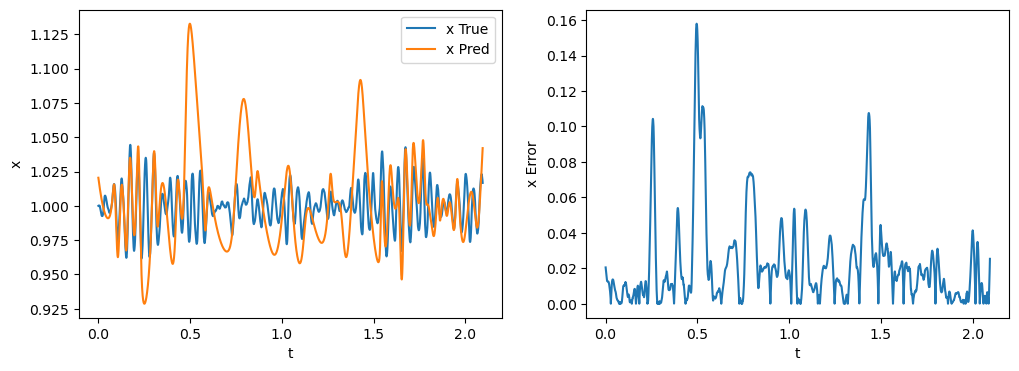

In [60]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(t_star.numpy().flatten(),x_true.flatten(),label='x True')
plt.plot(t_star.numpy().flatten(),x_pred.flatten(),label='x Pred')
plt.legend()
plt.xlabel('t')
plt.ylabel('x')

plt.subplot(122)
plt.plot(t_star.numpy().flatten(),abs(x_true.flatten() - x_pred.flatten()))
plt.xlabel('t')
plt.ylabel('x Error')
plt.show()

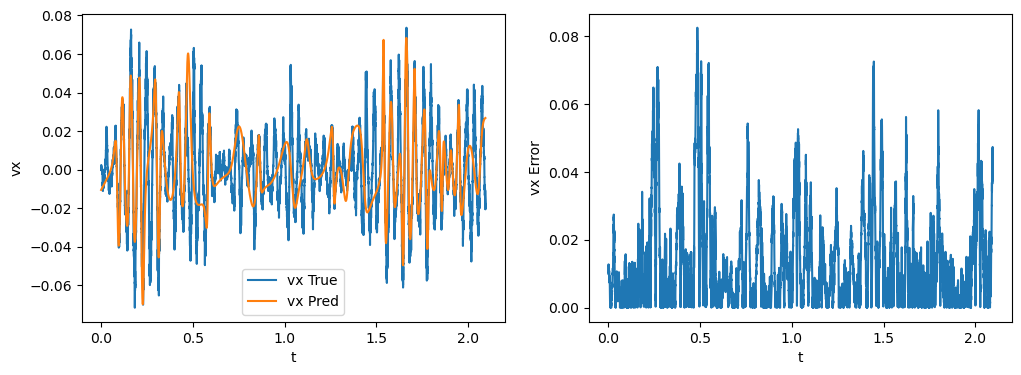

In [61]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(t_star.numpy().flatten(),vx_true.flatten(),label='vx True')
plt.plot(t_star.numpy().flatten(),vx_pred.flatten(),label='vx Pred')
plt.legend()
plt.xlabel('t')
plt.ylabel('vx')

plt.subplot(122)
plt.plot(t_star.numpy().flatten(),abs(vx_true.flatten() - vx_pred.flatten()))
plt.xlabel('t')
plt.ylabel('vx Error')

plt.show()

In [62]:
eqn = -beta*x_true**3/x_c**3

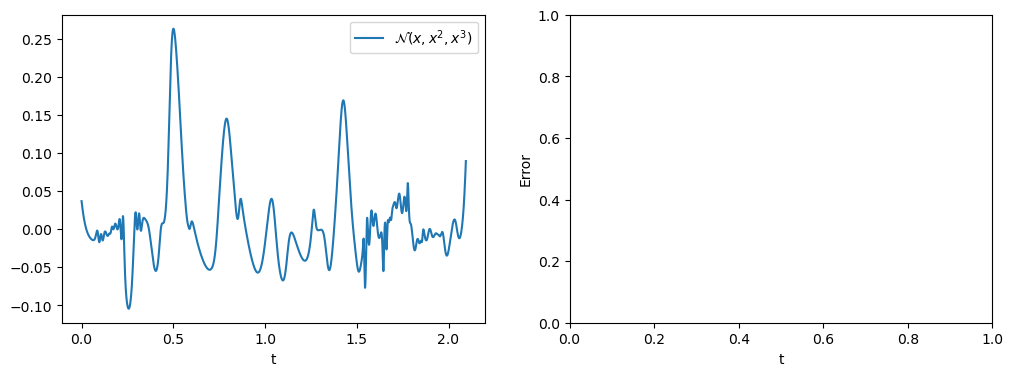

In [63]:
plt.figure(figsize=(12,4))
plt.subplot(121)
#plt.plot(t_star.numpy().flatten(),eqn.flatten(),label=r'$-\beta x^3$')
plt.plot(t_star.numpy().flatten(),N_hid_eqn.flatten(),label= r'$\mathcal{N}(x,x^2,x^3)$')
plt.legend()
plt.xlabel('t')

plt.subplot(122)
#plt.plot(t_star.numpy().flatten(),np.abs(eqn.flatten()-N_hid_eqn.flatten()))
plt.xlabel('t')
plt.ylabel('Error')
plt.show()